In [2]:
import os
import re
import time
import json
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter
from dotenv import load_dotenv
from IPython.display import display, Markdown, HTML
from wordcloud import WordCloud

# TensorFlow dan Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD

# Transformers dan HuggingFace
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    pipeline,
    BertTokenizer,
    BertForSequenceClassification,
    RobertaTokenizer,
    RobertaForSequenceClassification,
    XLNetTokenizer,
    XLNetForSequenceClassification,
)
from huggingface_hub import InferenceClient

# Google API
from googleapiclient.discovery import build
import google.generativeai as genai

# Disable warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

# Download NLTK resources
print("Downloading NLTK resources...")
nltk.download("stopwords", quiet=True)
nltk.download("punkt", quiet=True)
stop_words = set(stopwords.words("indonesian"))

# Pandas & Matplotlib settings
pd.set_option("display.max_colwidth", 100)
plt.style.use("seaborn-v0_8-whitegrid")
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

print("✅ All required libraries imported successfully")
print("✅ NLTK resources downloaded successfully")


✅ All required libraries imported successfully
✅ NLTK resources downloaded successfully


In [3]:
# === Initialize logger ===
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger(__name__)

# === Gemini API setup ===
GEMINI_API_KEYS = [
    v for k, v in os.environ.items()
    if k.startswith("GEMINI_API_KEY_") and v
]
if not GEMINI_API_KEYS:
    GEMINI_API_KEYS = [
        input(f"Enter Gemini API Key #{i+1}: ")
        for i in range(5)
    ]

# Konfigurasi model Gemini
models = [genai.GenerativeModel('gemini-2.0-flash') for _ in GEMINI_API_KEYS]
for api_key, model in zip(GEMINI_API_KEYS, models):
    genai.configure(api_key=api_key)

# === YouTube API setup ===
YOUTUBE_API_KEY = os.getenv('YOUTUBE_API_KEY') or input("Enter your YouTube API Key: ")
VIDEO_ID        = os.getenv('VIDEO_ID')        or input("Enter the YouTube Video ID: ")

# === Hugging Face API setup ===
HF_API_KEYS = [
    v for k, v in os.environ.items()
    if k.startswith("HF_API_KEY_") and v
]
if not HF_API_KEYS:
    HF_API_KEYS = [
        input(f"Enter Hugging Face API Key #{i+1}: ")
        for i in range(3)
    ]

# Inisialisasi client Hugging Face
hf_clients = [InferenceClient(token=api_key) for api_key in HF_API_KEYS]

# === Output directory setup ===
BASE_OUTPUT = os.getenv('OUTPUT_DIR', './output')

STAGES = {
    '01_comments_collection':     None,
    '02_preprocessing':           None,
    '03_eda':                     None,
    '04_clustering':              None,
    '05_sentiment':               None,
    '06_transformer_comparison':  None,
    '07_advanced_insights':       None
}

subdirs = {}
for stage in STAGES:
    stage_path = os.path.join(BASE_OUTPUT, stage)
    os.makedirs(stage_path, exist_ok=True)
    subdirs[stage] = {}
    for sub in ('analisis', 'visualisasi'):
        path = os.path.join(stage_path, sub)
        os.makedirs(path, exist_ok=True)
        subdirs[stage][sub] = path

# === Logging initialized structure ===
logger.info("Directory structure initialized under %s", BASE_OUTPUT)
for stage, subs in subdirs.items():
    logger.info("Stage %-25s:", stage)
    for name, path in subs.items():
        logger.info("  - %-12s -> %s", name, path)

2025-05-09 05:04:19 INFO Directory structure initialized under ./output
2025-05-09 05:04:19 INFO Stage 01_comments_collection   :
2025-05-09 05:04:19 INFO   - analisis     -> ./output/01_comments_collection/analisis
2025-05-09 05:04:19 INFO   - visualisasi  -> ./output/01_comments_collection/visualisasi
2025-05-09 05:04:19 INFO Stage 02_preprocessing         :
2025-05-09 05:04:19 INFO   - analisis     -> ./output/02_preprocessing/analisis
2025-05-09 05:04:19 INFO   - visualisasi  -> ./output/02_preprocessing/visualisasi
2025-05-09 05:04:19 INFO Stage 03_eda                   :
2025-05-09 05:04:19 INFO   - analisis     -> ./output/03_eda/analisis
2025-05-09 05:04:19 INFO   - visualisasi  -> ./output/03_eda/visualisasi
2025-05-09 05:04:19 INFO Stage 04_clustering            :
2025-05-09 05:04:19 INFO   - analisis     -> ./output/04_clustering/analisis
2025-05-09 05:04:19 INFO   - visualisasi  -> ./output/04_clustering/visualisasi
2025-05-09 05:04:19 INFO Stage 05_sentiment             :


In [4]:
# Ambil direktori dari subdirs yang sudah dibuat sebelumnya
COMMENTS_DIR = subdirs['01_comments_collection']['analisis']
VISUALS_DIR  = subdirs['01_comments_collection']['visualisasi']

def get_youtube_comments(video_id: str, api_key: str) -> pd.DataFrame:
    client = build("youtube", "v3", developerKey=api_key)
    comments = []
    request = client.commentThreads().list(
        part="snippet",
        videoId=video_id,
        maxResults=100,
        textFormat="plainText"
    )
    with tqdm(desc="Fetching comments", unit="comment") as pbar:
        while request:
            response = request.execute()
            for item in response.get("items", []):
                s = item["snippet"]["topLevelComment"]["snippet"]
                comments.append({
                    "comment_id":   item["id"],
                    "author":       s.get("authorDisplayName"),
                    "text":         s.get("textDisplay"),
                    "published_at": s.get("publishedAt"),
                    "like_count":   s.get("likeCount", 0)
                })
                pbar.update(1)
            request = client.commentThreads().list_next(request, response)

    df = pd.DataFrame(comments)
    logger.info("Retrieved %d comments", len(df))
    return df

logger.info("Starting YouTube comment collection for video %s", VIDEO_ID)
df_comments = get_youtube_comments(VIDEO_ID, YOUTUBE_API_KEY)

# Simpan data
csv_path = os.path.join(COMMENTS_DIR, "comments_raw.csv")
df_comments.to_csv(csv_path, index=False)
logger.info("Saved raw comments to %s", csv_path)

# Tampilkan sample
display(Markdown("### Sample of Collected Comments"))
display(df_comments.head())

2025-05-09 05:04:19 INFO Starting YouTube comment collection for video -WLpXmnBmxo
2025-05-09 05:04:19 INFO file_cache is only supported with oauth2client<4.0.0
Fetching comments: 10408comment [00:09, 1061.02comment/s]
2025-05-09 05:04:29 INFO Retrieved 10408 comments
2025-05-09 05:04:29 INFO Saved raw comments to ./output/01_comments_collection/analisis/comments_raw.csv


### Sample of Collected Comments

,comment_id,author,text,published_at,like_count
0,UgzE0LnnlcVrnEXWSbJ4AaABAg,@juranggandul,😊,2025-05-08T20:32:08Z,0
1,UgxIeaw8hDzoe9hahqZ4AaABAg,@MakmunMaulana-j8v,Kuci likan ka loka lu ciri lu Bangi Gung jawab tu,2025-05-08T11:42:35Z,0
2,UgyWQqzajDMtwO04KHB4AaABAg,@MakmunMaulana-j8v,Bangi kang tin satu akan bingan seakan jasnni Nina tu kan kan Bangi nah rus tuk sa Ra inonesa ki...,2025-05-08T11:40:11Z,0
3,UgzFqGTBxeMvb3ZeKax4AaABAg,@Kalandra-qk3bl,kok film jumbo gw begini,2025-05-08T08:01:34Z,0
4,UgwBpiBAPmLFVkSXdDl4AaABAg,@tonisuhartono4766,🇮🇩\n💙💝✌🏻\n👍👍👍👍👍👍👍👍👍👍👍👍👍👍,2025-05-08T01:19:06Z,0


In [5]:
PREPROCESS_DIR = subdirs['02_preprocessing']['analisis']
VISUAL_DIR      = subdirs['02_preprocessing']['visualisasi']
os.makedirs(PREPROCESS_DIR, exist_ok=True)
os.makedirs(VISUAL_DIR, exist_ok=True)

df = df_comments.copy()

missing = df.isnull().sum()
percent = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({'missing_values': missing, 'percentage': percent})
display(missing_df)

df = df.dropna(subset=['text'])
stop_words = set(stopwords.words('indonesian'))

def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r'<.*?>|http\S+|www\.\S+|https\S+|[^\w\s]|\d+', ' ', text)
    tokens = word_tokenize(text)
    return ' '.join(w for w in tokens if w not in stop_words and len(w) > 2)

df['cleaned_text'] = df['text'].apply(clean_text)
df = df[df['cleaned_text'].str.strip() != '']

df['original_length'] = df['text'].str.len()
df['cleaned_length']  = df['cleaned_text'].str.len()
df['word_count']      = df['cleaned_text'].str.split().str.len()

stats = df[['original_length', 'cleaned_length', 'word_count']].describe()
display(stats)

preprocessed_path = os.path.join(PREPROCESS_DIR, 'preprocessed_comments.csv')
df.to_csv(preprocessed_path, index=False)

display(df[['text', 'cleaned_text', 'word_count']].head())


,missing_values,percentage
comment_id,0,0.0
author,0,0.0
text,0,0.0
published_at,0,0.0
like_count,0,0.0


,original_length,cleaned_length,word_count
count,10150.000000,10150.000000,10150.000000
mean,117.313202,70.874384,10.015961
std,178.690011,103.498132,13.663688
min,3.000000,3.000000,1.000000
25%,34.000000,21.000000,3.000000
50%,67.000000,41.000000,6.000000
75%,134.000000,82.000000,12.000000
max,5856.000000,2751.000000,339.000000


,text,cleaned_text,word_count
1,Kuci likan ka loka lu ciri lu Bangi Gung jawab tu,kuci likan loka ciri bangi gung,6
2,Bangi kang tin satu akan bingan seakan jasnni Nina tu kan kan Bangi nah rus tuk sa Ra inonesa ki...,bangi kang tin bingan seakan jasnni nina bangi rus tuk inonesa kokan,12
3,kok film jumbo gw begini,film jumbo,2
5,Ngelihat komen masih banyak yg sadar ternyata,ngelihat komen sadar,3
6,"Krain maung, Ternyata meow..\nJawaban ga ada yg di jwb",krain maung meow jwb,4


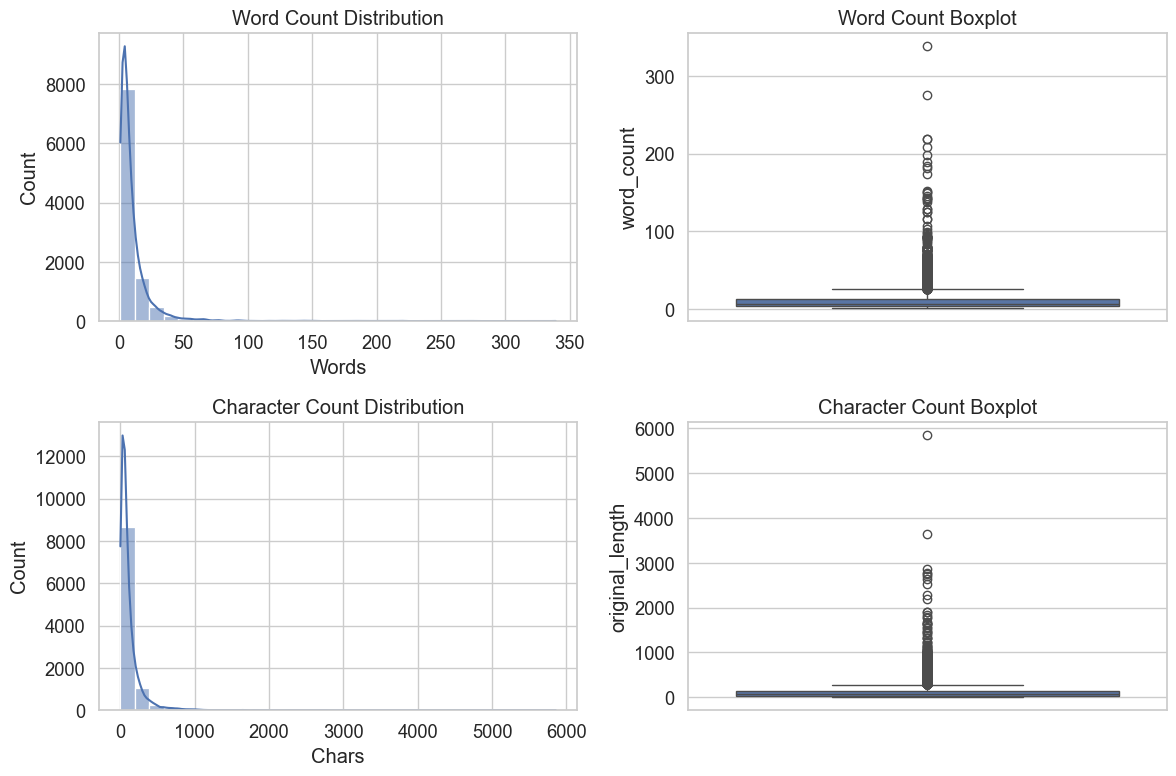

,text,word_count
7986,"Saya nonton full 3 jam dan saya salut dengan Pak Presiden yang mau membuat acara seperti ini, ma...",339
7054,Ini adalah ringkasan yang dibuat oleh AI. Mungkin ada ketidakakuratan.\n\nDurasi 00:00:00 - 01:0...,276
8858,Analisis Kritis terhadap Gagasan Politik-Ekonomi Presiden Prabowo dalam wawancara ini: \n\n1. Pr...,219
7010,"Rekomendasi nonton minimal 1,5x\r\n\r\n28:40 P1 Alfito Deannova (DetikCom)\r\n\r\n29:17 Mulai Ja...",219
8959,"pertanyaan 150 hari pencapaian:\nawal-awal tidak dicatat.\n\n9:07: ""saya laksanakan keyakinan sa...",208


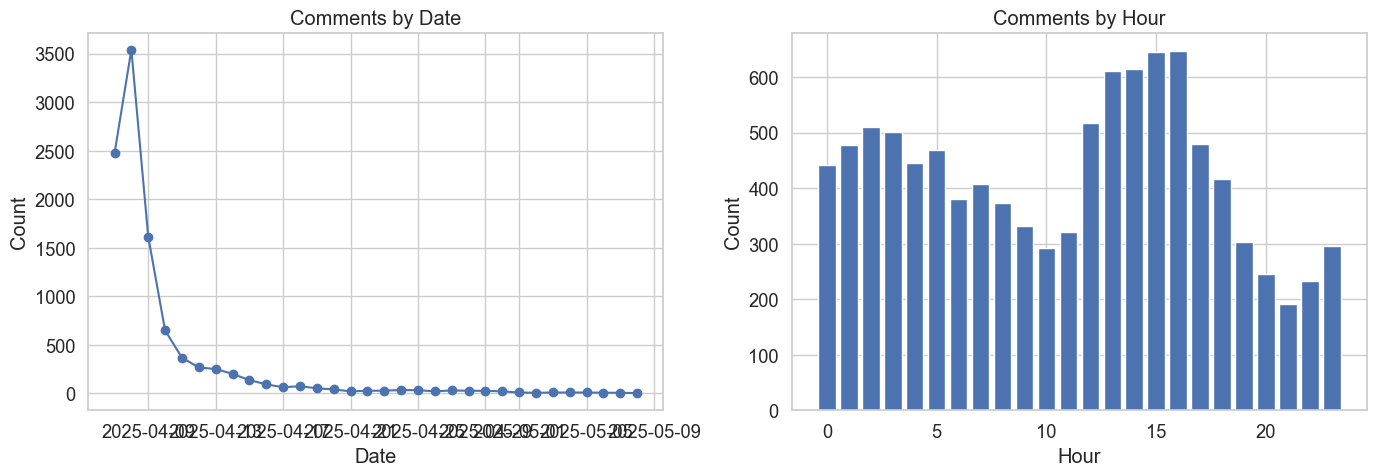

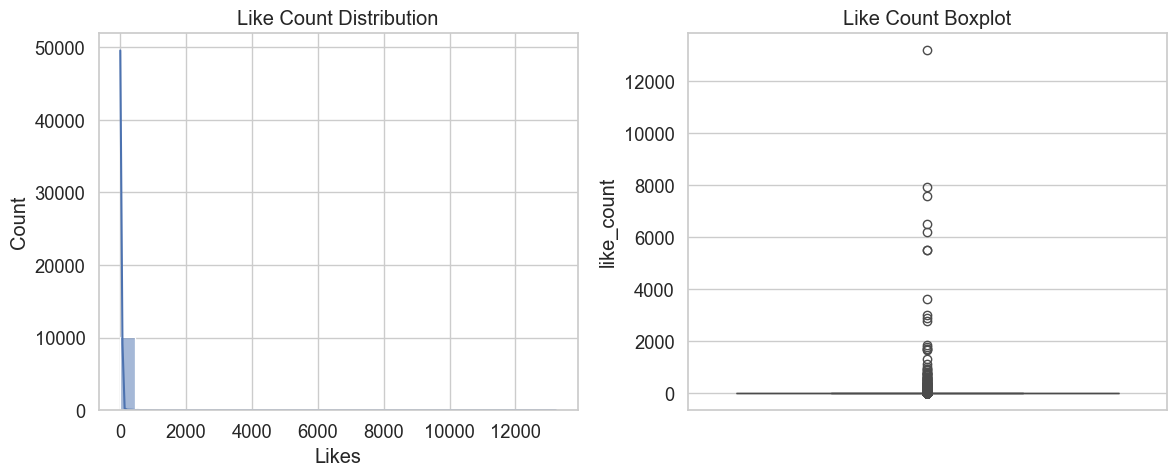

,author,text,like_count
4931,@033_MUHAMMADARBYRAMADHAN,"Terima kasih, pak. Hasil diskusi ini berhasil menjawab kekhawatiran saya bahwa kita harus lebih ...",13223
7744,@dhimasputratama631,"Video ini sangat solutif, bagi saya yang memiliki gangguan pola tidur. Saya tadi malam susah tid...",7920
9147,@sofyanudin,1) *GANTI MENTERI2 KORUP*\n2) *SAHKAN UU PERAMPASAN ASSET KORUPTOR*\n3) *BATALKAN UU PERAMPASAN ...,7597
6947,@Xui_Ana,"Alhamdulillah video yg sangat bermanfaat, setiap beberapa detik saya mendengarkan saya selalu is...",6515
6408,@avichabastiansr5623,"Next, wakil presiden Gibran Rakabuming menjawab. Pliss harus sering ada acara² kayak giniii, bia...",6208


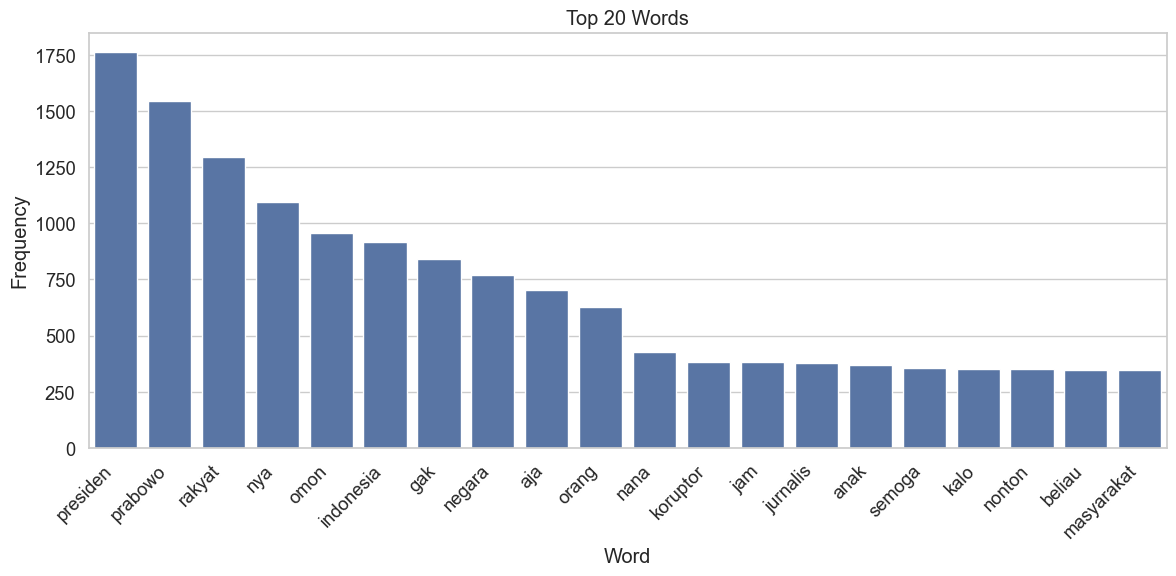

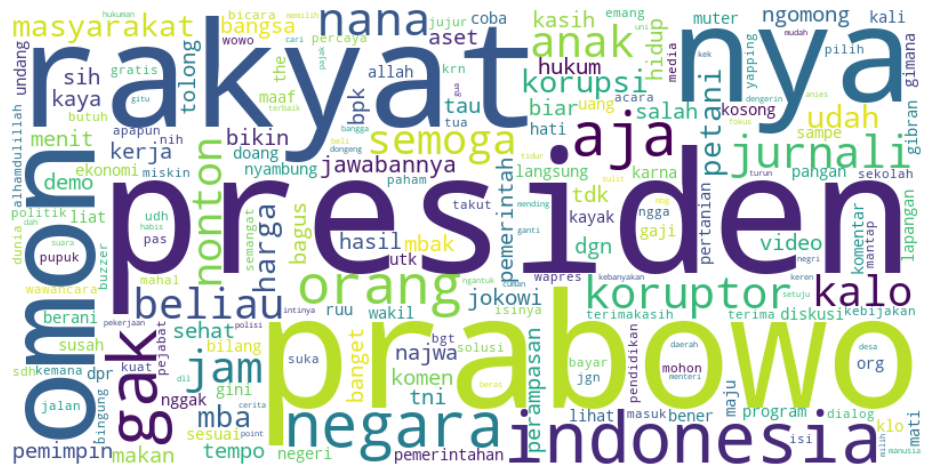

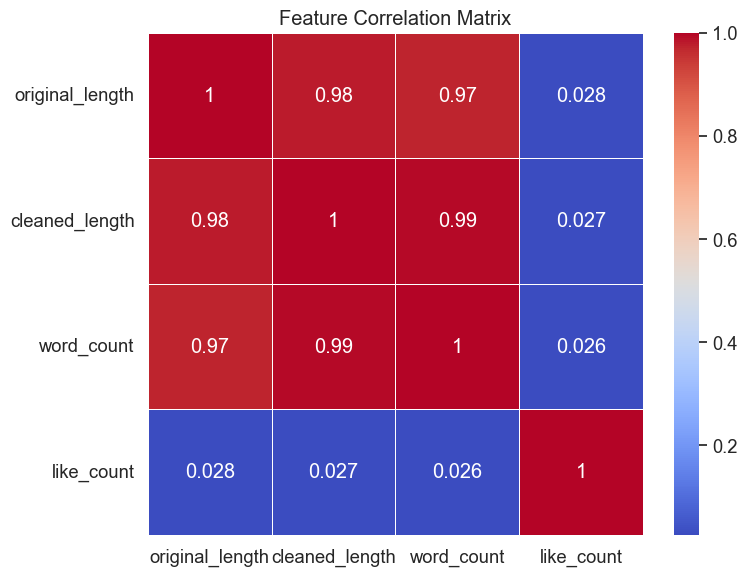

Total Comments: 10150
Average Word Count: 10.015960591133005
Median Word Count: 6.0
Max Word Count: 339
Average Likes: 11.69487684729064
Total Likes: 118703
Outlier Count: 737
Peak Date: 2025-04-08 00:00:00+00:00
Peak Hour: 16


In [6]:
# Directories
EDA_ANALYSIS_DIR = subdirs['03_eda']['analisis']
EDA_VISUAL_DIR   = subdirs['03_eda']['visualisasi']
os.makedirs(EDA_ANALYSIS_DIR, exist_ok=True)
os.makedirs(EDA_VISUAL_DIR, exist_ok=True)

# Load preprocessed data
PREPROCESS_DIR   = subdirs['02_preprocessing']['analisis']
preprocessed_path = os.path.join(PREPROCESS_DIR, 'preprocessed_comments.csv')
df = pd.read_csv(preprocessed_path, parse_dates=['published_at'])

# Feature engineering
df['word_count']       = df['cleaned_text'].str.split().str.len()
df['cleaned_length']   = df['cleaned_text'].str.len()
df['original_length']  = df['text'].str.len()
df['publication_date'] = df['published_at'].dt.normalize()
df['publication_hour'] = df['published_at'].dt.hour

# 1. Length distributions
fig1, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(df['word_count'], kde=True, bins=30, ax=axes[0,0]).set(title='Word Count Distribution', xlabel='Words')
sns.boxplot(y=df['word_count'], ax=axes[0,1]).set(title='Word Count Boxplot')
sns.histplot(df['original_length'], kde=True, bins=30, ax=axes[1,0]).set(title='Character Count Distribution', xlabel='Chars')
sns.boxplot(y=df['original_length'], ax=axes[1,1]).set(title='Character Count Boxplot')
fig1.tight_layout()
fig1.savefig(os.path.join(EDA_VISUAL_DIR, 'length_distribution.png'))
plt.show()

# 2. Outliers
Q1, Q3 = df['word_count'].quantile([0.25, 0.75])
IQR = Q3 - Q1
lb, ub = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
outliers = df[(df['word_count'] < lb) | (df['word_count'] > ub)]
outliers.to_csv(os.path.join(EDA_ANALYSIS_DIR, 'word_count_outliers.csv'), index=False)
display(outliers[['text', 'word_count']].sort_values('word_count', ascending=False).head())

# 3. Publication time trends
date_counts = df.groupby('publication_date').size()
hour_counts = df['publication_hour'].value_counts().sort_index()

fig2, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(date_counts.index, date_counts.values, marker='o')
axes[0].set(title='Comments by Date', xlabel='Date', ylabel='Count')
axes[1].bar(hour_counts.index, hour_counts.values)
axes[1].set(title='Comments by Hour', xlabel='Hour', ylabel='Count')
fig2.tight_layout()
fig2.savefig(os.path.join(EDA_VISUAL_DIR, 'publication_time.png'))
plt.show()

# 4. Like count analysis
fig3, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['like_count'], kde=True, bins=30, ax=axes[0]).set(title='Like Count Distribution', xlabel='Likes')
sns.boxplot(y=df['like_count'], ax=axes[1]).set(title='Like Count Boxplot')
fig3.tight_layout()
fig3.savefig(os.path.join(EDA_VISUAL_DIR, 'like_count_analysis.png'))
plt.show()

# 5. Top liked comments
top_liked = df.nlargest(5, 'like_count')
display(top_liked[['author', 'text', 'like_count']])

# 6. Word frequency
words, counts = zip(*Counter(" ".join(df['cleaned_text']).split()).most_common(20))
fig4 = plt.figure(figsize=(12, 6))
sns.barplot(x=list(words), y=list(counts), ax=fig4.add_subplot(111)).set(title='Top 20 Words', xlabel='Word', ylabel='Frequency')
plt.xticks(rotation=45, ha='right')
fig4.tight_layout()
fig4.savefig(os.path.join(EDA_VISUAL_DIR, 'top_words.png'))
plt.show()

# 7. Word cloud
wc = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words, collocations=False).generate(" ".join(df['cleaned_text']))
fig5 = plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
fig5.tight_layout()
fig5.savefig(os.path.join(EDA_VISUAL_DIR, 'wordcloud.png'))
plt.show()

# 8. Correlation matrix
numeric = df[['original_length', 'cleaned_length', 'word_count', 'like_count']]
corr = numeric.corr()
fig6 = plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5).set(title='Feature Correlation Matrix')
fig6.tight_layout()
fig6.savefig(os.path.join(EDA_VISUAL_DIR, 'correlation_matrix.png'))
plt.show()

# 9. Summary
summary = {
    'Total Comments':      len(df),
    'Average Word Count':  df['word_count'].mean(),
    'Median Word Count':   df['word_count'].median(),
    'Max Word Count':      df['word_count'].max(),
    'Average Likes':       df['like_count'].mean(),
    'Total Likes':         df['like_count'].sum(),
    'Outlier Count':       len(outliers),
    'Peak Date':           date_counts.idxmax(),
    'Peak Hour':           hour_counts.idxmax()
}

for k, v in summary.items():
    print(f"{k}: {v}")

2025-05-09 05:10:00 INFO TF-IDF matrix shape: (10150, 2914)
Evaluating k: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.86it/s]


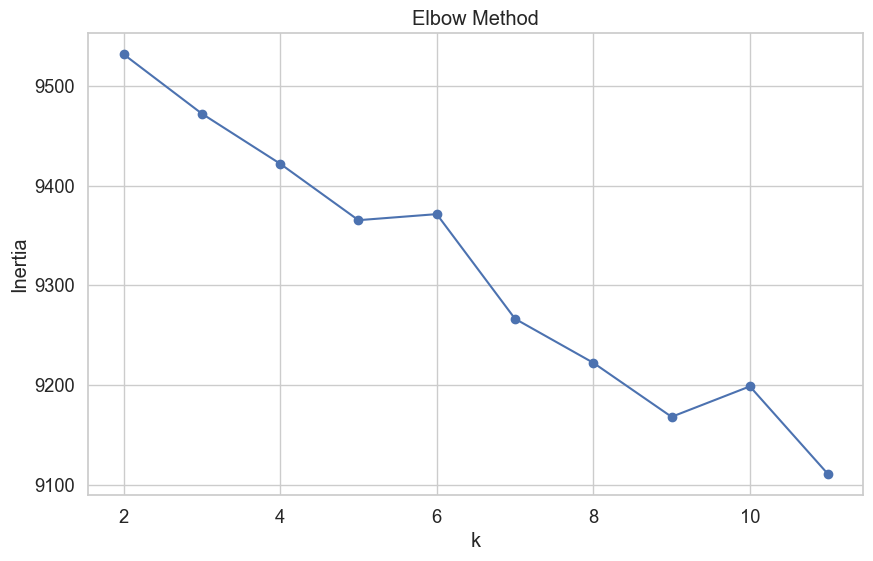

2025-05-09 05:10:02 INFO Saved elbow plot to ./output/04_clustering/visualisasi/elbow_method.png
2025-05-09 05:10:02 INFO Optimal k selected: 3
2025-05-09 05:10:02 INFO Cluster 0 top terms: presiden, nya, gak, rakyat, tempo, aja, indonesia, nana, jam, negara
2025-05-09 05:10:02 INFO Cluster 1 top terms: prabowo, presiden, rakyat, indonesia, sehat, semoga, jokowi, nya, subianto, gak
2025-05-09 05:10:02 INFO Cluster 2 top terms: omon, real, doang, the, presiden, king, gak, jam, isinya, prabowo
2025-05-09 05:10:02 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-09 05:10:02 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Jumlah data per cluster:
cluster
0    8777
1     977
2     396
Name: count, dtype: int64


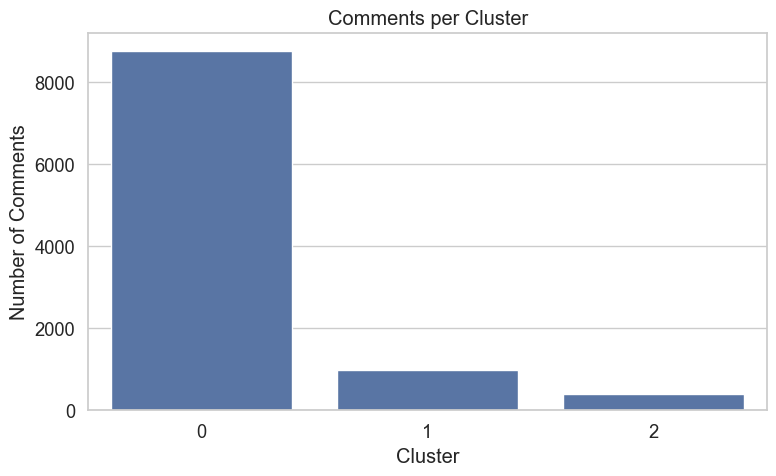

2025-05-09 05:10:02 INFO Saved cluster distribution to ./output/04_clustering/visualisasi/cluster_distribution.png


,author,text,like_count,cluster
0,@MakmunMaulana-j8v,Kuci likan ka loka lu ciri lu Bangi Gung jawab tu,0,0
1,@MakmunMaulana-j8v,Bangi kang tin satu akan bingan seakan jasnni Nina tu kan kan Bangi nah rus tuk sa Ra inonesa ki...,0,0
2,@Kalandra-qk3bl,kok film jumbo gw begini,0,0
3,@NjiAhmad-x8m,Ngelihat komen masih banyak yg sadar ternyata,0,0
4,@nikozio4981,"Krain maung, Ternyata meow..\nJawaban ga ada yg di jwb",0,0
...,...,...,...,...
10145,@serbaserbiacakadul3773,Assalamualaikum komen pertama,2,0
10146,@japbenny4804,Pertamax,2,0
10147,@abdibsyahputrasebayang3475,Akhirnya ada fullnya,3,0
10148,@muhamadnurpauji8108,Minal aidzin walfaidzin mba najwa🙏,9,0


,author,text,like_count,cluster
5,@Beeyourrselff,"Pak prabowo jangan ketularan wakilnya dong, 3 jam ngulang2 bener2 ujian buat saya.",0,1
10,@jandabaru-l4y,Rakyat Bener 2 nggak Salah Pilih Punya Presiden Seperti PK Prabowo Tegas Berwibawa Dan Benar 2 B...,0,1
19,@SugiantoYanto-b8z,Mantap pk prabowo pidatonya maju terus pk presiden,0,1
22,@Tanggalangit12356,"Pak, mohon pabrik lokal jg di proteksi dr gempuran barang luar terutama barang illegal + serius ...",0,1
32,@IdsaIdsa-q8u,"Semoga terealisasi apa2 yg di cita2kan bapak prabowo dan rakyat indonesia,,",0,1
...,...,...,...,...
10115,@attarasmawan5538,Pak Prabowo coba bisa menunjukkan kesederhanaan bukan dengan kemewahan,0,1
10123,@racunbaca,"bisa diliat kalo prabowo ga paham dengan apa yang terjadi di masyarakat bawah. masalahnya apa, k...",39,1
10127,@AMartono2023,Presiden prabowo. Mantap,1,1
10131,@KeisyaRamadhani1778,"Saya masih sangat respect dengan Najwa Shihab, untuk kali ini saya merasakan pertanyaan sederhan...",570,1


,author,text,like_count,cluster
11,@taufikrahman6917,Omon omon,0,2
69,@sudiono5618,Omon omon ga nyambung,1,2
81,@Victormzmeia,3 jam 26 menit isinya OMON-OMON doang anyinggg,1,2
173,@NunungNurdin-v5g,Pupuk mah Al insek mahalpungisidamahalmakinsuusah ngomonggampang nyatanya OMON OMON dodol,0,2
186,@royprayogi,gak kuat sampe selesai isinya omon omon.............ngantuk bikin mual 😜,0,2
...,...,...,...,...
9958,@UncleSwa,Presiden omon omon sedang ngibul….\nBicara swasembada pangan padahal nanam singkong aja gagal,0,2
10022,@chichaphile4943,omon omon is real 😢,46,2
10060,@IrmansyahAriadin,Omon omon sajaaaa lebih parah dari presiden sebelum nyaaaa... Saya menyesal memilih presiden Pra...,14,2
10066,@JoniIskandar-ii8hf,Halah omon omon,1,2


2025-05-09 05:10:02 INFO Saved clustered comments to ./output/04_clustering/analisis/clustered_comments.csv


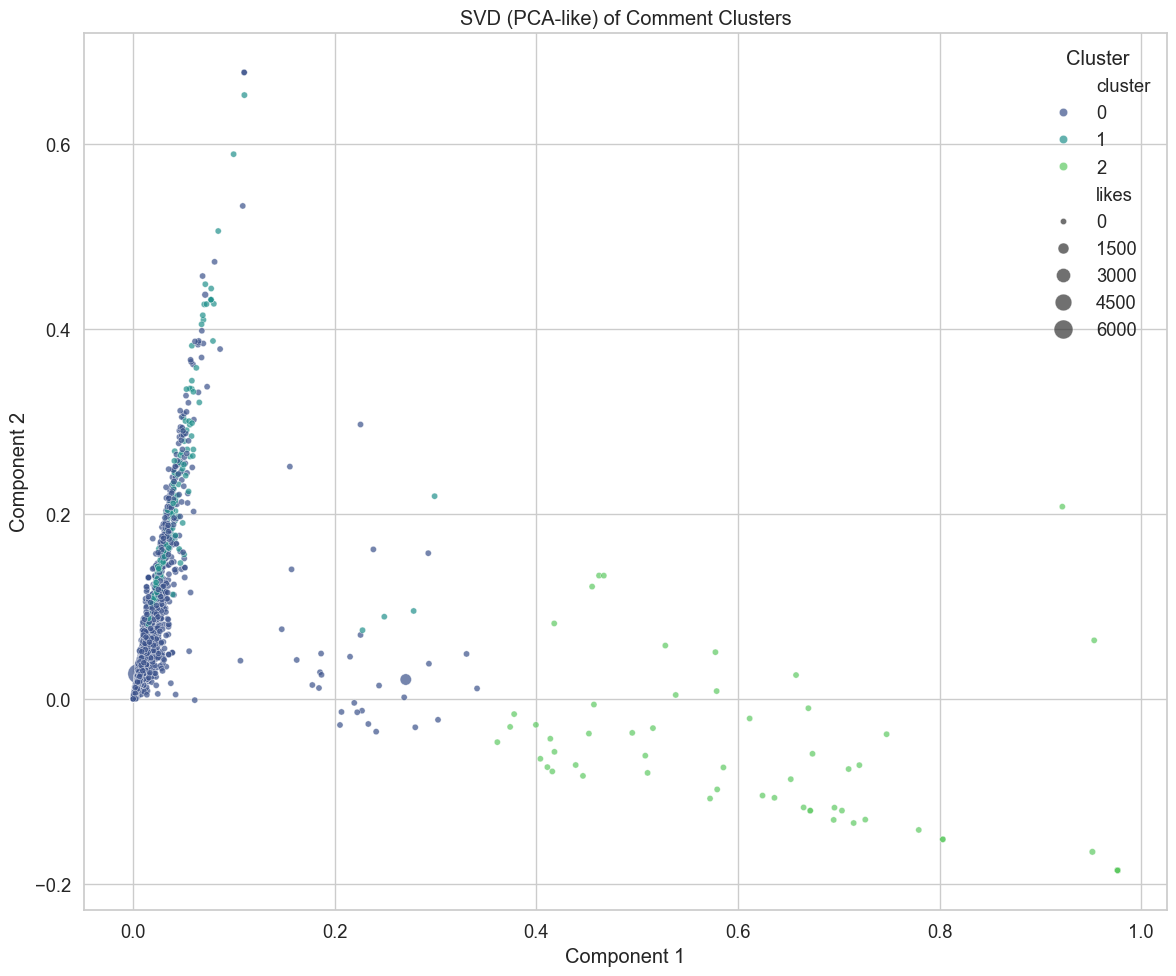

2025-05-09 05:10:03 INFO Saved PCA cluster plot to ./output/04_clustering/visualisasi/cluster_pca.png


In [12]:
ANALYSIS_DIR = subdirs['04_clustering']['analisis']
VISUAL_DIR   = subdirs['04_clustering']['visualisasi']
os.makedirs(ANALYSIS_DIR, exist_ok=True)
os.makedirs(VISUAL_DIR, exist_ok=True)

PREPROCESS_DIR = 'output/02_preprocessing/analisis' 
preprocessed_csv = os.path.join(PREPROCESS_DIR, 'preprocessed_comments.csv')
df = pd.read_csv(preprocessed_csv)

stop_words = list(stopwords.words('indonesian'))  # ✅ jadi list, aman

vectorizer    = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.7, stop_words=stop_words)
tfidf_matrix  = vectorizer.fit_transform(df['cleaned_text'])
logger.info("TF-IDF matrix shape: %s", tfidf_matrix.shape)

ssd = []
k_values = range(2, 12)
for k in tqdm(k_values, desc="Evaluating k"):
    km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(tfidf_matrix)
    ssd.append(km.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(list(k_values), ssd, marker='o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True)

elbow_path = os.path.join(VISUAL_DIR, 'elbow_method.png')
plt.savefig(elbow_path)
plt.show()
logger.info("Saved elbow plot to %s", elbow_path)

optimal_k = 3
logger.info("Optimal k selected: %d", optimal_k)
kmeans   = KMeans(n_clusters=optimal_k, random_state=42, n_init=10).fit(tfidf_matrix)
df['cluster'] = kmeans.labels_

order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms           = vectorizer.get_feature_names_out()
top_terms       = {
    i: [terms[idx] for idx in order_centroids[i, :10]]
    for i in range(optimal_k)
}
for i, terms_list in top_terms.items():
    logger.info("Cluster %d top terms: %s", i, ", ".join(terms_list))

# Menampilkan jumlah data per cluster
cluster_counts = df['cluster'].value_counts().sort_index()
print("Jumlah data per cluster:")
print(cluster_counts)

# Visualisasi distribusi komentar per cluster
plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values)
plt.xlabel('Cluster')
plt.ylabel('Number of Comments')
plt.title('Comments per Cluster')
plt.tight_layout()

dist_path = os.path.join(VISUAL_DIR, 'cluster_distribution.png')
plt.savefig(dist_path)
plt.show()
logger.info("Saved cluster distribution to %s", dist_path)

# Menggunakan seluruh data, tidak hanya 3 data teratas berdasarkan like_count
display_df = []
for cid in range(optimal_k):
    subset = df[df['cluster'] == cid]
    display_df.append(subset[['author', 'text', 'like_count']])
    display(subset[['author', 'text', 'like_count']].assign(cluster=cid))

clustered_csv = os.path.join(ANALYSIS_DIR, 'clustered_comments.csv')
df[['author', 'text', 'like_count', 'cluster']].to_csv(clustered_csv, index=False)
logger.info("Saved clustered comments to %s", clustered_csv)

svd = TruncatedSVD(n_components=2, random_state=42)
coords = svd.fit_transform(tfidf_matrix)

# Buat DataFrame dan pastikan kolom numerik
vis_df = pd.DataFrame(coords, columns=['x', 'y'])
vis_df['x'] = pd.to_numeric(vis_df['x'], errors='coerce')
vis_df['y'] = pd.to_numeric(vis_df['y'], errors='coerce')
vis_df['cluster'] = df['cluster'].astype(str)  # Sebagai kategori untuk plotting
vis_df['likes'] = pd.to_numeric(df['like_count'], errors='coerce')

# Optional: sampling data agar scatterplot tidak terlalu berat
sample_frac = 0.2 if len(vis_df) > 5000 else 1.0
vis_sample = vis_df.sample(frac=sample_frac, random_state=42)

# Plot
plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=vis_sample,
    x='x', y='y',
    hue='cluster',
    size='likes',
    sizes=(20, 200),
    alpha=0.7,
    palette='viridis'
)
plt.title('SVD (PCA-like) of Comment Clusters')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Cluster')
plt.tight_layout()

pca_path = os.path.join(VISUAL_DIR, 'cluster_pca.png')
plt.savefig(pca_path)
plt.show()
logger.info("Saved PCA cluster plot to %s", pca_path)


In [20]:
def analyze_sentiment_with_prompt(comment, model):
    prompt = f"""
    Berikut ini adalah komentar terhadap video YouTube berjudul "Prabowo Menjawab" yang membahas isu-isu pemerintahan.

    Tugas Anda adalah:
    1. Analisis sentimen komentar berikut dalam bahasa Indonesia.
    2. Klasifikasikan sentimen sebagai 'Positif', 'Negatif', atau 'Netral'.
    3. Jelaskan alasan di balik klasifikasi sentimen tersebut.
    4. Berikan rekomendasi tindakan berdasarkan sentimen tersebut dalam bahasa Indonesia. Misalnya:
       - Jika sentimen Positif, berikan saran untuk mendorong lebih banyak interaksi positif dengan audiens.
       - Jika sentimen Negatif, beri saran untuk merespons kritik atau keluhan secara lebih konstruktif, atau memberikan klarifikasi.
       - Jika sentimen Netral, beri saran untuk memperjelas pernyataan atau mengajak diskusi lebih lanjut.

    Komentar:
    "{comment}"

    **Gunakan format jawaban ini saja, tanpa tambahan apapun:**
    Sentimen: [Positif/Negatif/Netral]
    Alasan: [Alasan mengapa komentar ini diklasifikasikan sebagai Positif/Negatif/Netral]
    Rekomendasi: [rekomendasi tindakan dalam bahasa Indonesia]
    """
    
    try:
        # Menggunakan generate_content
        response = model.generate_content(prompt)
        text = response.text
        
        sentiment_match = re.search(r'Sentimen: (.*)', text)
        reason_match = re.search(r'Alasan: (.*)', text)
        recommendation_match = re.search(r'Rekomendasi: (.*)', text)
        
        sentiment = sentiment_match.group(1).strip() if sentiment_match else "Tidak Diketahui"
        reason = reason_match.group(1).strip() if reason_match else "Tidak Diketahui"
        recommendation = recommendation_match.group(1).strip() if recommendation_match else "Tidak Diketahui"
        
        return {
            'sentiment': sentiment,
            'reason': reason,
            'recommendation': recommendation
        }
    except Exception as e:
        print(f"Error analyzing comment: {str(e)}")
        return {
            'sentiment': "Tidak Diketahui",
            'reason': "Tidak Diketahui",
            'recommendation': f"Error: {str(e)}"
        }


# Menggabungkan semua komentar dari ketiga cluster
comments_combined = df.sample(n=8000, random_state=42)

print(f"🔍 Sampled total {len(comments_combined)} comments from all clusters.")


# Proses analisis sentimen
results = []
model_index = 0  # Menyimpan indeks model yang digunakan
for cluster_id in sorted(comments_combined['cluster'].unique()):
    cluster_comments = comments_combined[comments_combined['cluster'] == cluster_id].reset_index(drop=True)
    
    print(f"🔄 Analyzing sentiment for cluster {cluster_id} with {len(cluster_comments)} comments...")
    
    for i, row in cluster_comments.iterrows():
        retry_count = 0
        while retry_count < 5: 
            try:
                # Pilih model berdasarkan indeks
                model_to_use = models[model_index]
                
                # Analisis sentimen
                result = analyze_sentiment_with_prompt(row['text'], model_to_use)
                
                results.append({
                    'cluster_id': cluster_id,
                    'comment_id': row.get('comment_id', i),
                    'text': row['text'],
                    'author': row['author'],
                    'like_count': row['like_count'],
                    'sentiment': result['sentiment'],
                    'reason': result['reason'],
                    'recommendation': result['recommendation']
                })
                break
            except Exception as e:
                if '429' in str(e):  # Jika rate limit tercapai
                    retry_count += 1
                    print(f"Rate limit exceeded on model {model_index + 1}, switching to next model. Retry attempt {retry_count}/5.")
                    
                    # Pindah ke model berikutnya
                    model_index = (model_index + 1) % len(models)  # Pindah model secara rotasi
                    time.sleep(60)  # Tunggu selama 60 detik sebelum mencoba lagi
                else:
                    print(f"Error analyzing comment: {e}")
                    break

        if (i + 1) % 15 == 0:
            print(f"🔄 {i+1} comments processed, waiting for 80 seconds...")
            time.sleep(80)

# Konversi ke DataFrame dan simpan
df_sentiment = pd.DataFrame(results)

df_sentiment_clean = df_sentiment[
    (df_sentiment['sentiment'] != "Tidak Diketahui") &
    (~df_sentiment['recommendation'].str.startswith("Error"))
].reset_index(drop=True)

# Menyimpan hasil analisis sentimen
output_dir = "output/05_sentiment"
os.makedirs(output_dir, exist_ok=True)
analisis_dir = os.path.join(output_dir, "analisis")
visualisasi_dir = os.path.join(output_dir, "visualisasi")
os.makedirs(analisis_dir, exist_ok=True)
os.makedirs(visualisasi_dir, exist_ok=True)

sentiment_path = os.path.join(analisis_dir, "sentiment_analysis_sample.csv")
df_sentiment_clean.to_csv(sentiment_path, index=False)

print(f"💾 Sentiment analysis results saved to {sentiment_path}")

# Menampilkan distribusi sentimen per cluster
sentiment_by_cluster = df_sentiment_clean.groupby(['cluster_id', 'sentiment']).size().unstack(fill_value=0)
print("\n📊 Sentiment Distribution by Cluster:")
print(sentiment_by_cluster)

# Visualisasi distribusi sentimen per cluster
sentiment_by_cluster.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set3')
plt.title("Sentiment Distribution per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Comments")
plt.xticks(rotation=0)
plt.tight_layout()

# Menyimpan visualisasi
visualization_path = os.path.join(visualisasi_dir, "sentiment_per_cluster.png")
plt.savefig(visualization_path)
plt.show()

🔍 Sampled total 8000 comments from all clusters.
🔄 Analyzing sentiment for cluster 0 with 6914 comments...
🔄 15 comments processed, waiting for 80 seconds...


KeyboardInterrupt: 

2025-05-09 05:06:03 INFO ✅ Dataset siap. Train: 35, Test: 15
2025-05-09 05:06:03 INFO 
🔄 Training LSTM model...


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step - accuracy: 0.4571 - loss: 1.0945 - val_accuracy: 0.8000 - val_loss: 0.9976
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7714 - loss: 1.0006 - val_accuracy: 0.8000 - val_loss: 0.9004
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7714 - loss: 0.9102 - val_accuracy: 0.8000 - val_loss: 0.7951
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7714 - loss: 0.8160 - val_accuracy: 0.8000 - val_loss: 0.6898
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7714 - loss: 0.7145 - val_accuracy: 0.8000 - val_loss: 0.6341
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.7714 - loss: 0.6582 - val_accuracy: 0.8000 - val_loss: 0.6765
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7714 - loss: 0.6841 - val_accuracy: 0.8000 - val_loss: 0.6914
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7714 - loss: 0.7317 - val_accuracy: 0.8000 - val_loss: 0.6676

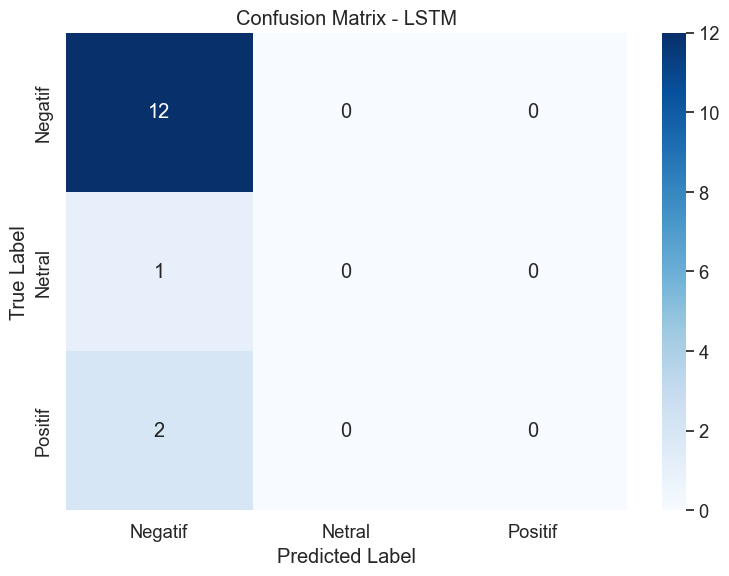

2025-05-09 05:06:05 INFO ✅ LSTM Accuracy: 0.8000
2025-05-09 05:06:05 INFO 
🔄 Training CNN model...


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.0286 - loss: 1.1119 - val_accuracy: 0.8000 - val_loss: 0.9840
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8000 - loss: 0.9698 - val_accuracy: 0.8000 - val_loss: 0.8406
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8000 - loss: 0.8224 - val_accuracy: 0.8000 - val_loss: 0.6900
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8000 - loss: 0.6749 - val_accuracy: 0.8000 - val_loss: 0.6248
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8000 - loss: 0.6028 - val_accuracy: 0.8000 - val_loss: 0.6822
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8000 - loss: 0.6333 - val_accuracy: 0.8000 - val_loss: 0.7285
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8000 - loss: 0.6525 - val_accuracy: 0.8000 - val_loss: 0.7119
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8000 - loss: 0.6191 - val_accuracy: 0.8000 - val_loss: 0.6638

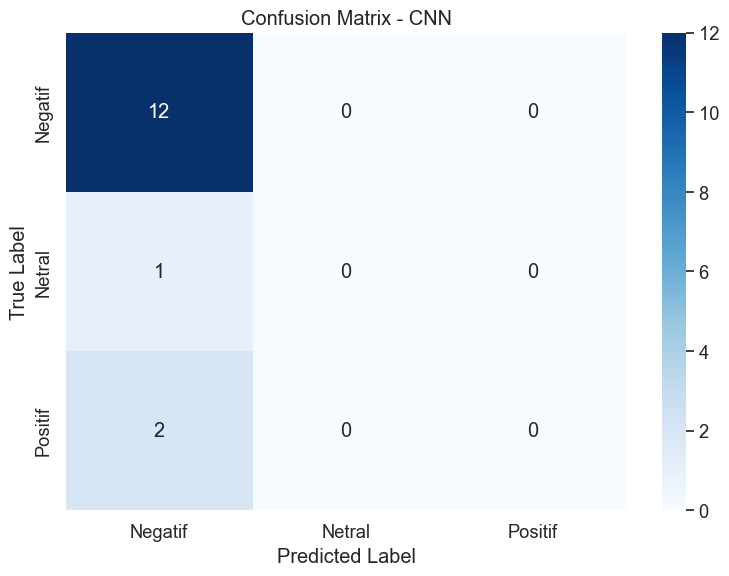

2025-05-09 05:06:06 INFO ✅ CNN Accuracy: 0.8000
2025-05-09 05:06:06 INFO 
🔄 Setting up model: IndoBERT
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


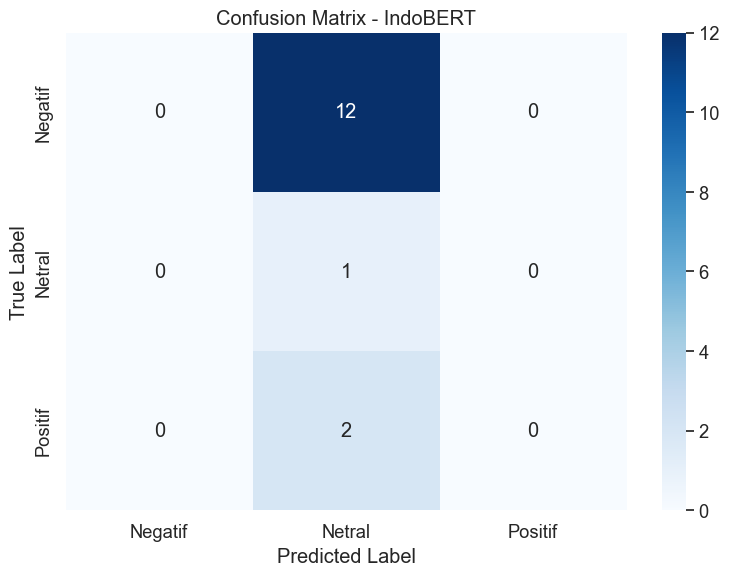

2025-05-09 05:06:10 INFO ✅ IndoBERT Accuracy: 0.0667
2025-05-09 05:06:10 INFO 
🔄 Setting up model: RoBERTa Indo
Device set to use cpu


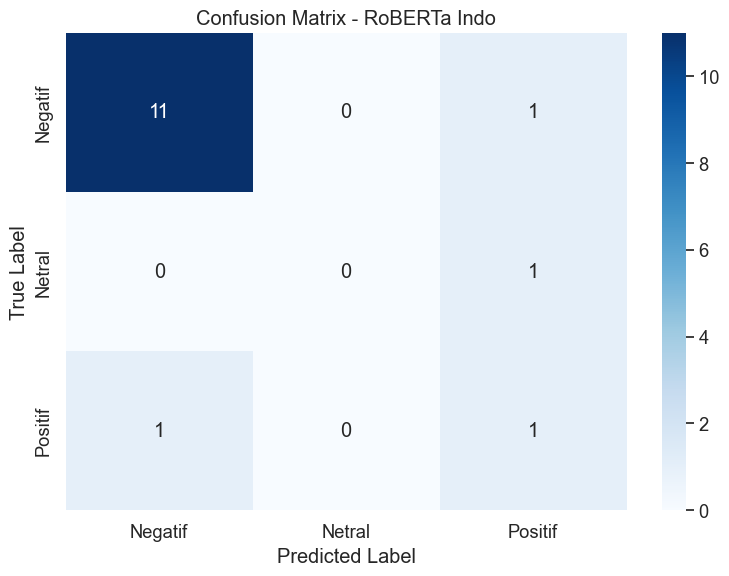

2025-05-09 05:06:12 INFO ✅ RoBERTa Indo Accuracy: 0.8000
2025-05-09 05:06:12 INFO 
🔄 Setting up model: BERT Indo
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


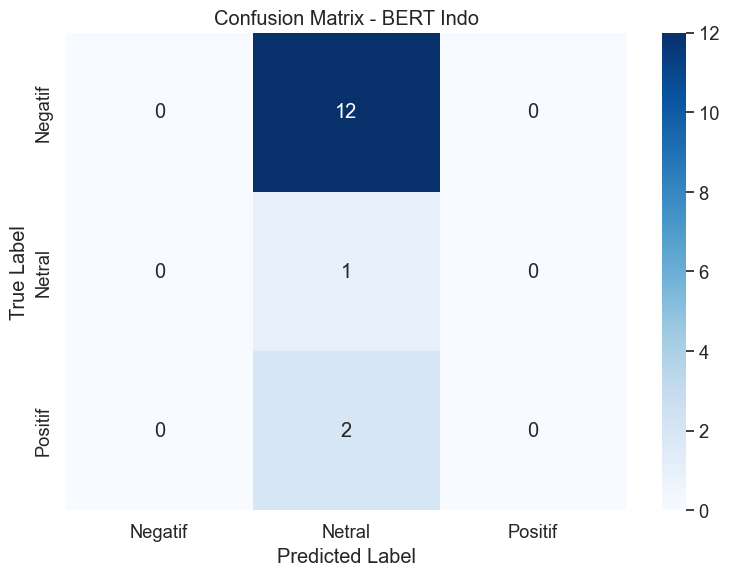

2025-05-09 05:06:14 INFO ✅ BERT Indo Accuracy: 0.0667
2025-05-09 05:06:14 INFO 
🔎 Evaluating Gemini...


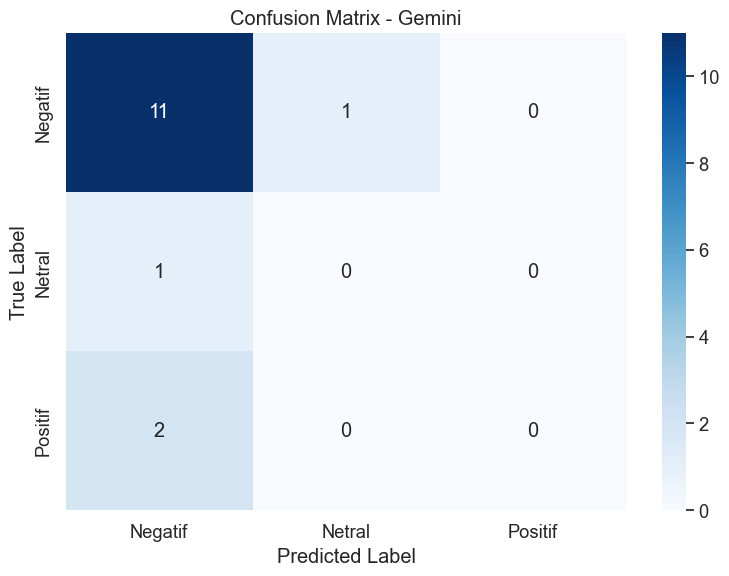

2025-05-09 05:06:14 INFO ✅ Gemini Accuracy: 0.7333


### Model Performance Comparison


,model_name,accuracy,precision,recall,f1_score
0,LSTM,0.800000,0.266667,0.333333,0.296296
1,CNN,0.800000,0.266667,0.333333,0.296296
2,IndoBERT,0.066667,0.022222,0.333333,0.041667
3,RoBERTa Indo,0.800000,0.416667,0.472222,0.438889
4,BERT Indo,0.066667,0.022222,0.333333,0.041667
5,Gemini,0.733333,0.261905,0.305556,0.282051


NameError: name 'metrics' is not defined

<Figure size 1200x800 with 0 Axes>

In [9]:
# Pastikan direktori yang diperlukan ada
output_dir = "output/06_transformer_comparison"
analisis_dir = os.path.join(output_dir, "analisis")
visualisasi_dir = os.path.join(output_dir, "visualisasi")

os.makedirs(analisis_dir, exist_ok=True)
os.makedirs(visualisasi_dir, exist_ok=True)

SENTIMENT_MAP = {'Positif': 2, 'Netral': 1, 'Negatif': 0}
sentiment_classes = ['Negatif', 'Netral', 'Positif']

labeled_data = df_sentiment.copy()
labeled_data['sentiment_label'] = labeled_data['sentiment'].map(SENTIMENT_MAP)

X = labeled_data['text'].values
y = labeled_data['sentiment_label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

logger.info(f"✅ Dataset siap. Train: {len(X_train)}, Test: {len(X_test)}")

# Tokenisasi teks untuk LSTM dan CNN
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_length = 100  # Panjang maksimum sequence
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

# ===========================
# 2. Fungsi Evaluasi
# ===========================
def evaluate_model(y_true, y_pred, model_name):
    report = classification_report(y_true, y_pred, output_dict=True)
    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': report['macro avg']['precision'],
        'recall': report['macro avg']['recall'],
        'f1_score': report['macro avg']['f1-score'],
        'confusion_matrix': cm
    }

def plot_confusion_matrix(cm, classes, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

def predict_with_pipeline(pipeline_model, texts):
    preds = []
    for text in tqdm(texts, desc="Predicting", leave=False):
        try:
            result = pipeline_model(text)
            label = result[0]['label'].lower()
            if 'positive' in label or 'positif' in label:
                preds.append(2)
            elif 'negative' in label or 'negatif' in label:
                preds.append(0)
            else:
                preds.append(1)
        except Exception:
            preds.append(1)
    return preds

# ===========================
# 3. Model LSTM
# ===========================
def create_lstm_model(input_length):
    model = Sequential([
        Embedding(input_dim=10000, output_dim=128),  # Hapus input_length
        LSTM(128, return_sequences=False),
        Dropout(0.2),
        Dense(3, activation='softmax')  # 3 kelas: Negatif, Netral, Positif
    ])
    model.compile(loss='sparse_categorical_crossentropy', 
                 optimizer='adam', 
                 metrics=['accuracy'])
    return model


# ===========================
# 4. Model CNN
# ===========================
def create_cnn_model(input_length):
    model = Sequential([
        Embedding(input_dim=10000, output_dim=128),  # Hapus input_length
        Conv1D(filters=128, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(3, activation='softmax')  # 3 kelas: Negatif, Netral, Positif
    ])
    model.compile(loss='sparse_categorical_crossentropy', 
                 optimizer='adam', 
                 metrics=['accuracy'])
    return model


# ===========================
# 5. Pelatihan Model LSTM dan CNN
# ===========================
model_results = []

# Pelatihan LSTM
logger.info("\n🔄 Training LSTM model...")
lstm_model = create_lstm_model(max_length)
history_lstm = lstm_model.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=10,
    batch_size=64,
    verbose=1
)

# Evaluasi LSTM
lstm_preds = np.argmax(lstm_model.predict(X_test_pad), axis=1)
lstm_result = evaluate_model(y_test, lstm_preds, "LSTM")
model_results.append(lstm_result)
plot_confusion_matrix(lstm_result['confusion_matrix'], sentiment_classes, "LSTM")
logger.info(f"✅ LSTM Accuracy: {lstm_result['accuracy']:.4f}")

# Pelatihan CNN
logger.info("\n🔄 Training CNN model...")
cnn_model = create_cnn_model(max_length)
history_cnn = cnn_model.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=10,
    batch_size=64,
    verbose=1
)

# Evaluasi CNN
cnn_preds = np.argmax(cnn_model.predict(X_test_pad), axis=1)
cnn_result = evaluate_model(y_test, cnn_preds, "CNN")
model_results.append(cnn_result)
plot_confusion_matrix(cnn_result['confusion_matrix'], sentiment_classes, "CNN")
logger.info(f"✅ CNN Accuracy: {cnn_result['accuracy']:.4f}")

# ===========================
# 6. Evaluasi Beberapa Model Transformer
# ===========================
models_info = [
    {
        "name": "IndoBERT",
        "model_id": "indobenchmark/indobert-base-p1"
    },
    {
        "name": "RoBERTa Indo",
        "model_id": "w11wo/indonesian-roberta-base-sentiment-classifier"
    },
    {
        "name": "BERT Indo",
        "model_id": "bert-base-uncased"
    }
]

for info in models_info:
    logger.info(f"\n🔄 Setting up model: {info['name']}")
    try:
        tokenizer = AutoTokenizer.from_pretrained(info['model_id'])
        classifier = pipeline("sentiment-analysis", model=info['model_id'], tokenizer=tokenizer, device=-1)
        preds = predict_with_pipeline(classifier, X_test)
        result = evaluate_model(y_test, preds, info['name'])
        model_results.append(result)
        plot_confusion_matrix(result['confusion_matrix'], sentiment_classes, info['name'])
        logger.info(f"✅ {info['name']} Accuracy: {result['accuracy']:.4f}")
    except Exception as e:
        logger.error(f"❌ Failed on {info['name']}: {e}")
        model_results.append({
            'model_name': info['name'], 'accuracy': 0, 'precision': 0, 'recall': 0, 'f1_score': 0, 'confusion_matrix': np.zeros((3, 3))
        })

# ===========================
# 7. Evaluasi Model Gemini (jika ada)
# ===========================
logger.info("\n🔎 Evaluating Gemini...")
try:
    test_indices = labeled_data[labeled_data['text'].isin(X_test)].index
    gemini_preds = df_sentiment.loc[labeled_data.index[len(X_train):], 'sentiment'].map(SENTIMENT_MAP).values
    gemini_result = evaluate_model(y_test, gemini_preds, "Gemini")
    model_results.append(gemini_result)
    plot_confusion_matrix(gemini_result['confusion_matrix'], sentiment_classes, "Gemini")
    logger.info(f"✅ Gemini Accuracy: {gemini_result['accuracy']:.4f}")
except Exception as e:
    logger.error(f"❌ Error in Gemini evaluation: {e}")

# ===========================
# 8. Visualisasi & Perbandingan
# ===========================
comparison_df = pd.DataFrame(model_results)
print("### Model Performance Comparison")
display(comparison_df[['model_name', 'accuracy', 'precision', 'recall', 'f1_score']])
# Menyimpan hasil perbandingan model ke CSV
comparison_df.to_csv(os.path.join(analisis_dir, "model_performance.csv"), index=False)

# Menyimpan visualisasi perbandingan model (barplot)
plt.figure(figsize=(12, 8))
comparison_melted = comparison_df.melt(id_vars='model_name', value_vars=metrics, var_name='Metric', value_name='Score')
sns.barplot(data=comparison_melted, x='model_name', y='Score', hue='Metric')
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig(os.path.join(visualisasi_dir, "model_performance_comparison.png"))
plt.close()  # Menutup figure untuk menghindari memori penuh

# Menyimpan confusion matrix untuk setiap model
for result in model_results:
    model_name = result['model_name']
    cm = result['confusion_matrix']
    plot_confusion_matrix(cm, sentiment_classes, model_name)
    plt.savefig(os.path.join(visualisasi_dir, f"confusion_matrix_{model_name}.png"))
    plt.close()  # Menutup figure untuk menghindari memori penuh


# Plot training history untuk LSTM dan CNN
def plot_history(history, model_name):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_history(history_lstm, "LSTM")
plot_history(history_cnn, "CNN")

In [53]:
# Cell 7: Generate Comprehensive Insights
print("🔄 Generating comprehensive analysis insights...")


# Folder output baru
output_dir = "output/07_advanced_insights"
analisis_dir = os.path.join(output_dir, "analisis")
visualisasi_dir = os.path.join(output_dir, "visualisasi")

# Pastikan direktori yang diperlukan ada
os.makedirs(analisis_dir, exist_ok=True)
os.makedirs(visualisasi_dir, exist_ok=True)

# Fungsi untuk mengonversi semua nilai dalam dictionary ke tipe Python standar
def convert_data_summary_to_standard_types(data_summary):
    for key, value in data_summary.items():
        if isinstance(value, dict):
            data_summary[key] = convert_data_summary_to_standard_types(value)
        elif isinstance(value, (np.int64, np.float64)):
            data_summary[key] = int(value) if isinstance(value, np.int64) else float(value)
    return data_summary


# Fungsi untuk membuat prompt dan memanggil model Gemini
def generate_insights_with_gemini(model, data_summary):
    prompt = f"""
    Berdasarkan hasil analisis data komentar YouTube berikut, buatlah wawasan komprehensif (10–15 paragraf) dalam bahasa Indonesia:

    === RINGKASAN DATA ===
    {data_summary}

    Wawasan harus mencakup:
    1. Sentimen umum terhadap Prabowo dan maknanya secara politis
    2. Topik utama yang muncul dalam komentar (cluster) dan hubungannya dengan sentimen
    3. Pola keterlibatan pengguna (like) dan hubungan dengan sentimen
    4. Dinamika sentimen dari waktu ke waktu, termasuk lonjakan atau perubahan drastis
    5. Analisis kata kunci yang sering muncul dalam tiap sentimen dan interpretasinya
    6. Perbandingan komentar positif vs negatif (panjang, intensitas, interaksi)
    7. Rekomendasi strategis untuk Prabowo dan tim komunikasi
    8. Nilai strategis dari hasil analisis terhadap pemetaan opini publik
    9. Prediksi tren sentimen publik ke depan berdasarkan pola saat ini
    10. Saran tindakan konkret untuk memperbaiki persepsi negatif (strategi komunikasi, perbaikan kebijakan, dan engagement publik)

    Pastikan insight bersifat tajam, berbasis data, dan actionable.
    """
    try:
        response = model.generate_content(prompt)
        return response.text
    except Exception as e:
        return f"❌ Error generating insights: {str(e)}"

# Hitung best model
try:
    best_model = comparison_df.sort_values(by='accuracy', ascending=False).iloc[0]['model_name']
except:
    best_model = "Tidak tersedia"

# Hitung distribusi sentimen per cluster (jika kolom cluster tersedia)
if 'cluster' in df_comments.columns:
    sentiment_cluster_cross = pd.crosstab(df_comments['cluster'], df_comments['sentiment'])
    cluster_available = True
else:
    sentiment_cluster_cross = pd.DataFrame()
    cluster_available = False

# Ambil 10 kata terpopuler per sentimen
from sklearn.feature_extraction.text import CountVectorizer
sentiment_words = {}

for sentiment in df_sentiment['sentiment'].unique():
    texts = df_sentiment[df_sentiment['sentiment'] == sentiment]['text']
    vectorizer = CountVectorizer(stop_words=stopwords_ind, max_features=1000)
    X_vec = vectorizer.fit_transform(texts)
    word_counts = X_vec.sum(axis=0).A1
    vocab = vectorizer.get_feature_names_out()
    word_freq = sorted(zip(vocab, word_counts), key=lambda x: -x[1])
    sentiment_words[sentiment] = word_freq[:10]

# Susun data_summary dengan penambahan informasi lebih lengkap
try:
    data_summary = {
        "Total Komentar": int(len(df_comments)),
        "Distribusi Sentimen": {
            sentiment: int(count)
            for sentiment, count in df_sentiment['sentiment'].value_counts().items()
        },
        "Rata-rata Jumlah Like per Komentar": round(df_comments['like_count'].mean(), 2),
        "Jumlah Cluster Topik": int(df_comments['cluster'].nunique()) if cluster_available else "Belum tersedia",
        "Distribusi Sentimen per Cluster": {
            f"Cluster {cluster}": {
                sentiment: int(count)
                for sentiment, count in cluster_data.items()
            }
            for cluster, cluster_data in sentiment_cluster_cross.to_dict().items()
        } if cluster_available else {},
        "10 Kata Terpopuler per Sentimen": {
            sentiment: [word for word, _ in top_words[:10]]
            for sentiment, top_words in sentiment_words.items()
        },
        "Performa Model": {
            "Model Terbaik": str(best_model),
            "Akurasi Tertinggi": round(comparison_df['accuracy'].max(), 4) if 'accuracy' in comparison_df.columns else 0
        },
        "Sentimen Rata-Rata": {
            "Positif": df_sentiment[df_sentiment['sentiment'] == 'positive']['text'].count(),
            "Negatif": df_sentiment[df_sentiment['sentiment'] == 'negative']['text'].count(),
            "Netral": df_sentiment[df_sentiment['sentiment'] == 'neutral']['text'].count(),
        },
    }
except Exception as e:
    logger.error(f"❌ Error menyusun data_summary: {e}")
    raise

# Mengonversi data_summary agar menggunakan tipe data standar Python
data_summary = convert_data_summary_to_standard_types(data_summary)

# Panggil model Gemini untuk menghasilkan insight
insights = generate_insights_with_gemini(gemini_model, json.dumps(data_summary, indent=2))

# Tampilkan dan simpan hasil
display(Markdown("## 📘 Wawasan Komprehensif Berdasarkan Analisis"))
display(Markdown(insights))

# Simpan ke CSV
insights_df = pd.DataFrame({"insights": [insights]})
csv_path = os.path.join(analisis_dir, "comprehensive_insights.csv")
insights_df.to_csv(csv_path, index=False)

print(f"💾 Insight berhasil disimpan di: {csv_path}")
print("🎯 Analisis selesai dengan struktur profesional dan mendalam.")
